# Generating the original audio signal given the output of CAR FAC

In this code the original input is reconstructed from the output of CAR FAC model using the inverse of BM transfer function measured by this model. for this purpose a class is defined with all the synthesizing parameters and processes defined as its properties.
Synthesis class consists of an initialization function with all the BM parameters as its input so each object of this class can be customized for different conditions with different cochlear characteristics for example various number of channels and frequecy ranges, hearing disorders or other specific condition. for instance:

object = synthesis(200) 

gives us an object of this class in which the BM model has 200 sections. Notice that all the parameters are set with default values from CAR FAC model. There are other variables defined with static initial values as class properties. Also this class has 3 ohter functions as below:
 - transfer_function : cochlear transfer function measurement
 - input_reconstructor: estimating the original input sound
 - BM model: calculating the output of CAR FAC for selected input
 - wavPlayer: playing sounds

In [69]:
%matplotlib notebook
from pylab import *
from scipy import signal
import colorsys
import scipy.constants as const
import scipy
from scipy.io import wavfile
from IPython.core.display import HTML
from mpl_toolkits.mplot3d import Axes3D
from __future__ import division

class Synthesis:

    f0 = 0.001                    # sweep start frequency
    f1 = 20000                    # sweep end frequency
    gain = 0.1                    # input gain
    tau_in = 10e-3                # p329 transmitter creation time constant   
    tau_out = 0.5e-3              # p329 transmitter depletion time constant
    tau_IHC = 80e-6               # p329 ~8kHz LPF for IHC output
    scale = 0.1                   # p313 NLF parameter
    offset = 0.04                 # p313 NLF parameter 
    b = 1.0                       # automatic gain loop feedback (1=no undamping).
    
    def __init__(self,sec_number = 100,srate = 32000,npt = 64000,low_freq = 0.10,high_freq = 0.90,damping = 0.2,f_hpf = 20):
        
        self.fs = srate                                     # sample frequency
        self.npoints = npt
        self.dur = self.npoints/self.fs                     # stimulus length
        self.t1 = arange(self.npoints)/self.fs              # sample times
        self.stimulus = 0.9*signal.chirp(self.t1, self.f0, self.t1[-1], self.f1, method='logarithmic', phi=-90)  # create input tone
        self.c_in = 1/(self.fs*self.tau_in)                                # p329 corresponding IIR coefficient
        self.c_out = 1/(self.fs*self.tau_out)                              # p329 corresponding IIR coefficient
        self.c_IHC = 1/(self.fs*self.tau_IHC)                              # corresponding IIR coefficient
        self.nsec = sec_number                              # number of sections in the cochlea between
        xlow = low_freq                                     # lowest frequency position along the cochlea and
        xhigh = high_freq                                   # highest frequency position along the cochlea
        x = linspace(xhigh,xlow,self.nsec)                  # position along the cochlea 1 = base, 0 = apex
        f = 165.4*(10**(2.1*x)-1)                           # Greenwood for humans
        self.a0 = cos(2*pi*f/self.fs)                       # a0 and c0 control the poles and zeros
        self.c0 = sin(2*pi*f/self.fs)
        self.r = 1 - damping*2*pi*f/self.fs                 # pole & zero radius actual
        self.r1 = 1 - damping*2*pi*f/self.fs                # pole & zero radius minimum (set point)
        self.h = self.c0                                         # p302 h=c0 puts the zeros 1/2 octave above poles
        self.g = (1-2*self.a0*self.r+self.r*self.r)/(1-(2*self.a0-self.h*self.c0)*self.r+self.r*self.r)  # p303 this gives 0dB DC gain for BM
        self.q = 1/(1+(2*pi*f_hpf/self.fs))                 # corresponding IIR coefficient
        self.d_rz = 0.7*(1 - self.r1)                            # p310 relative undamping
        self.W0 = zeros(self.nsec)                          # BM filter internal state
        self.W1 = zeros(self.nsec)                          # BM filter internal state
        self.W1old = zeros(self.nsec)                       # BM filter internal state at t-1
        self.BM = zeros((self.nsec,self.npoints))           # BM displacement
        self.BM_hpf = zeros((self.nsec,self.npoints))       # BM displacement high-pass filtered at 20Hz
        self.trans = ones(self.nsec)                        # transmitter available
        self.IHC = zeros((self.nsec,self.npoints))          # IHC output
        self.IHCa = zeros((self.nsec,self.npoints))         # IHC filter internal state
        self.BM_transfer_func = fft(zeros((self.nsec,self.npoints)))   # Basilar membrane transfer function



    def transfer_function(self):
        
        self.BM[-1] = self.stimulus             # put stimulus at BM[-1] to provide input to BM[0]
        self.BM[-1,-1] = 0                      # hack to make BM_hpf[nsec-1,0] work
        for t in range(self.npoints):
            for s in range(self.nsec):
                self.W0new = self.BM[s-1,t] + self.r[s]*(self.a0[s]*self.W0[s] - self.c0[s]*self.W1[s])
                self.W1[s] = self.r[s]*(self.a0[s]*self.W1[s] + self.c0[s]*self.W0[s])
                self.W0[s] = self.W0new
                self.BM[s,t] = self.g[s]*(self.BM[s-1,t] + self.h[s]*self.W1[s])
            self.BM_hpf[:,t] = self.q*(self.BM_hpf[:,t-1] + self.BM[:,t] - self.BM[:,t-1])
            self.z = (self.BM_hpf[:,t]+0.175).clip(0)   # p328
            self.v_mem = self.z**3/(self.z**3+self.z**2+0.1)      # p328
            self.IHC_new = self.v_mem*self.trans    
            self.trans += self.c_in*(1-self.trans) - self.c_out*self.IHC_new   
            self.IHCa[:,t] = (1-self.c_IHC)*self.IHCa[:,t-1] + self.c_IHC*self.IHC_new
            self.IHC[:,t] = (1-self.c_IHC)*self.IHC[:,t-1] + self.c_IHC*self.IHCa[:,t]
            self.v_OHC = self.W1 - self.W1old
            self.W1old = self.W1.copy()
            self.sqr=(self.v_OHC*self.scale+self.offset)**2
            self.NLF= 1/(1 + (self.scale*self.v_OHC + self.offset)**2)
            self.r = self.r1 + self.d_rz*(1-self.b)*self.NLF
            self.g = (1-2*self.a0*self.r+self.r*self.r)/(1-(2*self.a0-self.h*self.c0)*self.r+self.r*self.r)
        output = self.BM_hpf               # use this signal as the output signal
        self.BM_transfer_func = fft(zeros((self.nsec,self.npoints)))
        for s in range(self.nsec):
            self.BM_transfer_func[s] = fft(output[s])/fft(self.stimulus)
        return self.BM_transfer_func+10e-100
    
    def BM_model(self,stimulus):
        
        self.BM[-1] = stimulus             # put stimulus at BM[-1] to provide input to BM[0]
        self.BM[-1,-1] = 0                 # hack to make BM_hpf[nsec-1,0] work
        for t in range(self.npoints):
            for s in range(self.nsec):
                self.W0new = self.BM[s-1,t] + self.r[s]*(self.a0[s]*self.W0[s] - self.c0[s]*self.W1[s])
                self.W1[s] = self.r[s]*(self.a0[s]*self.W1[s] + self.c0[s]*self.W0[s])
                self.W0[s] = self.W0new
                self.BM[s,t] = self.g[s]*(self.BM[s-1,t] + self.h[s]*self.W1[s])
            self.BM_hpf[:,t] = self.q*(self.BM_hpf[:,t-1] + self.BM[:,t] - self.BM[:,t-1])
            self.z = (self.BM_hpf[:,t]+0.175).clip(0)   # p328
            self.v_mem = self.z**3/(self.z**3+self.z**2+0.1)      # p328
            self.IHC_new = self.v_mem*self.trans    
            self.trans += self.c_in*(1-self.trans) - self.c_out*self.IHC_new   
            self.IHCa[:,t] = (1-self.c_IHC)*self.IHCa[:,t-1] + self.c_IHC*self.IHC_new
            self.IHC[:,t] = (1-self.c_IHC)*self.IHC[:,t-1] + self.c_IHC*self.IHCa[:,t]
            self.v_OHC = self.W1 - self.W1old
            self.W1old = self.W1.copy()
            self.sqr=(self.v_OHC*self.scale+self.offset)**2
            self.NLF= 1/(1 + (self.scale*self.v_OHC + self.offset)**2)
            self.r = self.r1 + self.d_rz*(1-self.b)*self.NLF
            self.g = (1-2*self.a0*self.r+self.r*self.r)/(1-(2*self.a0-self.h*self.c0)*self.r+self.r*self.r)
        return self.BM_hpf               # use this signal as the output signal
        
    
    def input_reconstructor(self,BM_output,BM_trans_func):
        
        frequency_domain_input = fft(zeros(self.npoints))                              #Initializing frequancy-domain input array
        for s in range(10,self.nsec):                                                     #Summing up the output of
            frequency_domain_input += 1/self.nsec*(fft(BM_output[s])/BM_trans_func[s])                #all the synthesis filterbank channels
        time_domain_input = real(ifft(frequency_domain_input))                         #Time-domain original input estimation
        return time_domain_input
    
    def wavPlayer(self,filepath):
        """ will display html 5 player for compatible browser

        Parameters :
        ------------
        filepath : relative filepath with respect to the notebook directory ( where the .ipynb are not cwd)
                   of the file to play

        """

        src = """
        <head>
        <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
        <title>Listen To The Sound</title>
        </head>

        <body>
        <audio controls="controls" style="width:600px" >
          <source src="files/%s" type="audio/mp3" />
          Your browser does not support the audio element.
        </audio>
        </body>
        """%(filepath)
        display(HTML(src))
    

At this step we can choose a random speech signal (VCV) to test the process with:

In [70]:
Audio_file_path = 'audios/S10M_L014_V2_M1_N1_CS0.wav'   #ALA
# Audio_file_path = 'audios/S10M_L014_V2_M1_N2_CS0.wav'   #ALA
# Audio_file_path = 'audios/S10M_L014_V2_M1_N3_CS0.wav'   #ALA
# Audio_file_path = 'audios/S10M_L014_V3_M1_N1_CS0.wav'   #ALA
# Audio_file_path = 'audios/sp15.wav'   #ALA

In [71]:
sample_rate , input_audio = wavfile.read(Audio_file_path, mmap = False)    #Reading the audio file
original_npoints = size(input_audio)
Analyser = Synthesis(100,sample_rate,original_npoints)                     #An object for BM analysis with original audio features
Analyser.wavPlayer(Audio_file_path)                                        #Passing the original audio to player
BM_output = Analyser.BM_model(input_audio)                                 #Output of BM model analysis (based on CAR) for original audio
print("The original audio fs:", sample_rate)
print("The original audio number of samples:", original_npoints)

The original audio fs: 16000
The original audio number of samples: 23616


In [72]:
print(size(BM_output,0))
print(size(BM_output,1))

100
23616


In [73]:
Synthesizer = Synthesis(100,sample_rate,original_npoints)                  #An object for synthesizing original audio from BM model output
BM_tf = Synthesizer.transfer_function()                                    #Measuring the transfer function based on CAR

In [74]:
print(size(BM_tf,0))
print(size(BM_tf,1))

100
23616


Syntesizing original input using transfer function

In [75]:
synt_audio = Synthesizer.input_reconstructor(BM_output,BM_tf)              #Synthesizing the etimasted input signal using output and TF

estimated_audio = synt_audio[0:original_npoints]

wavfile.write('estimated.wav', sample_rate, estimated_audio.astype(np.int16))   #Saving the synthesized input as a file
Synthesizer.wavPlayer("estimated.wav")                                          #Passing the synthesized estimated input to player


Calculating RMSE

In [76]:

sample_Diff = input_audio - estimated_audio
RMSE = 1/original_npoints*sqrt(sum((sample_Diff)**2))
print("Root Mean Square Error:",RMSE)

Root Mean Square Error: 5.6091774832605905


<IPython.core.display.Javascript object>


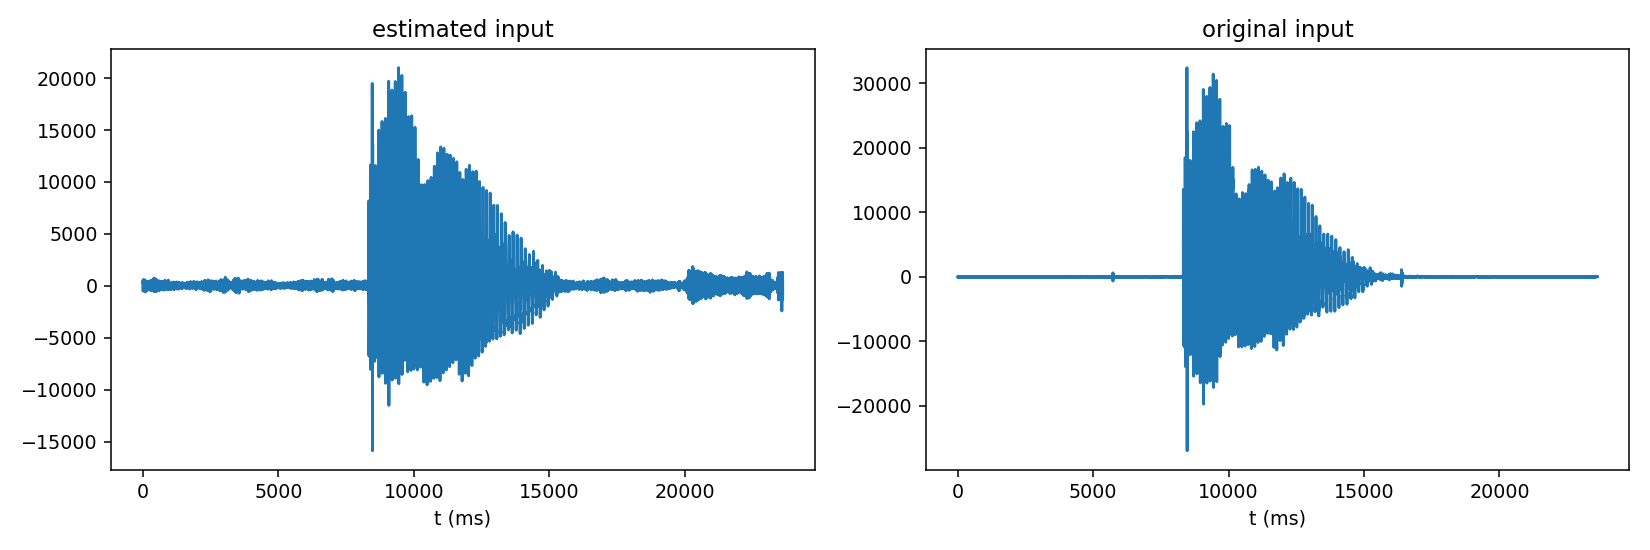

In [77]:
estimated_t = arange(original_npoints)/sample_rate
figure(2, figsize=(12,4))                                                                                                                    #with the original input signal
# ---------------------------------Plot of estimated input ---------------------------------------------
estimated_input = subplot(1,2,1)
plot(estimated_audio)
# plot(estimated_t,synt_audio,'g')                         #Difference between original and estimated signals (in samples)
xlabel('t (ms)')
title('estimated input')
# ---------------------------------Plot of original input ---------------------------------------------
orignal_input = subplot(1,2,2,sharex=estimated_input)
plot(input_audio)
xlabel('t (ms)')
title('original input')
tight_layout()

<IPython.core.display.Javascript object>


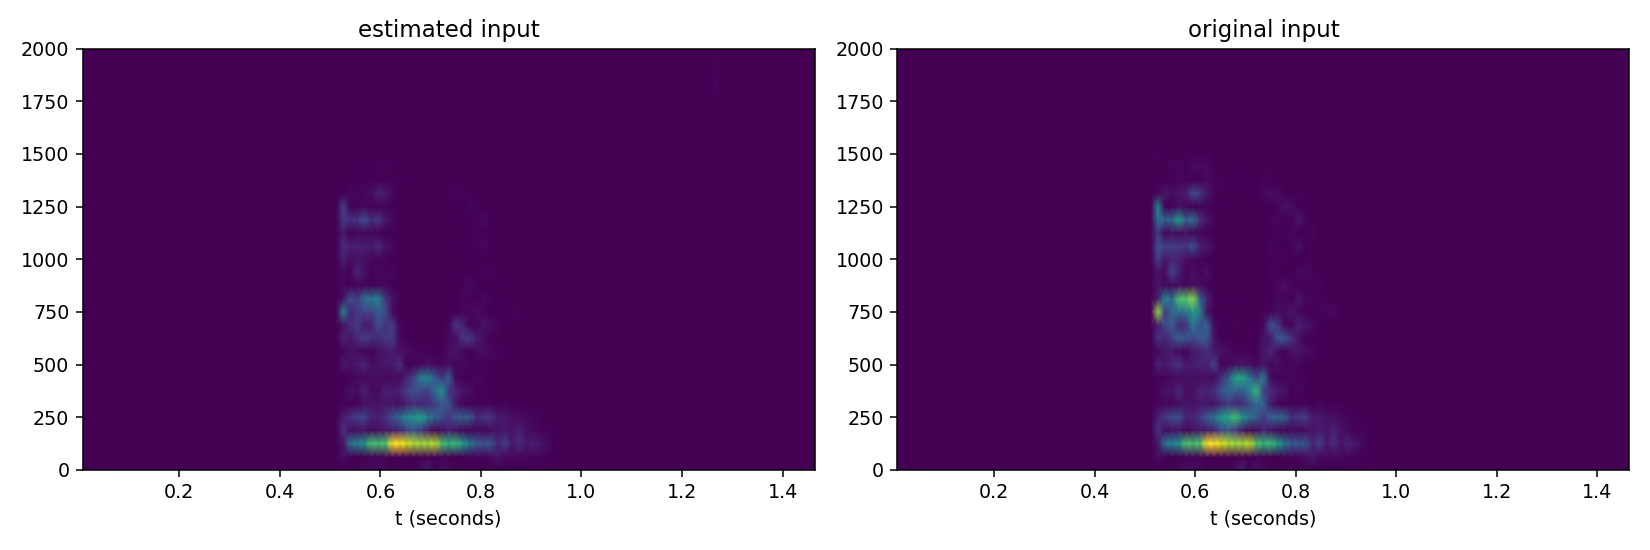

In [78]:
estimated_t = arange(original_npoints)/sample_rate
figure(4, figsize=(12,4))                                                                                                                    #with the original input signal
# ---------------------------------Plot of estimated input ---------------------------------------------
estimated_input = subplot(1,2,1)
f, t, Sxx = signal.spectrogram(estimated_audio,sample_rate)
plt.pcolormesh(t, f, Sxx, shading='gouraud')                        
xlabel('t (seconds)')
ylim([0, 2000])
title('estimated input')
# ---------------------------------Plot of original input ---------------------------------------------
orignal_input = subplot(1,2,2)
f, t, Sxx = signal.spectrogram(input_audio,sample_rate)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
xlabel('t (seconds)')
title('original input')
ylim([0, 2000])
tight_layout()

In [79]:
b=Synthesis(100,32000,64000)


<IPython.core.display.Javascript object>


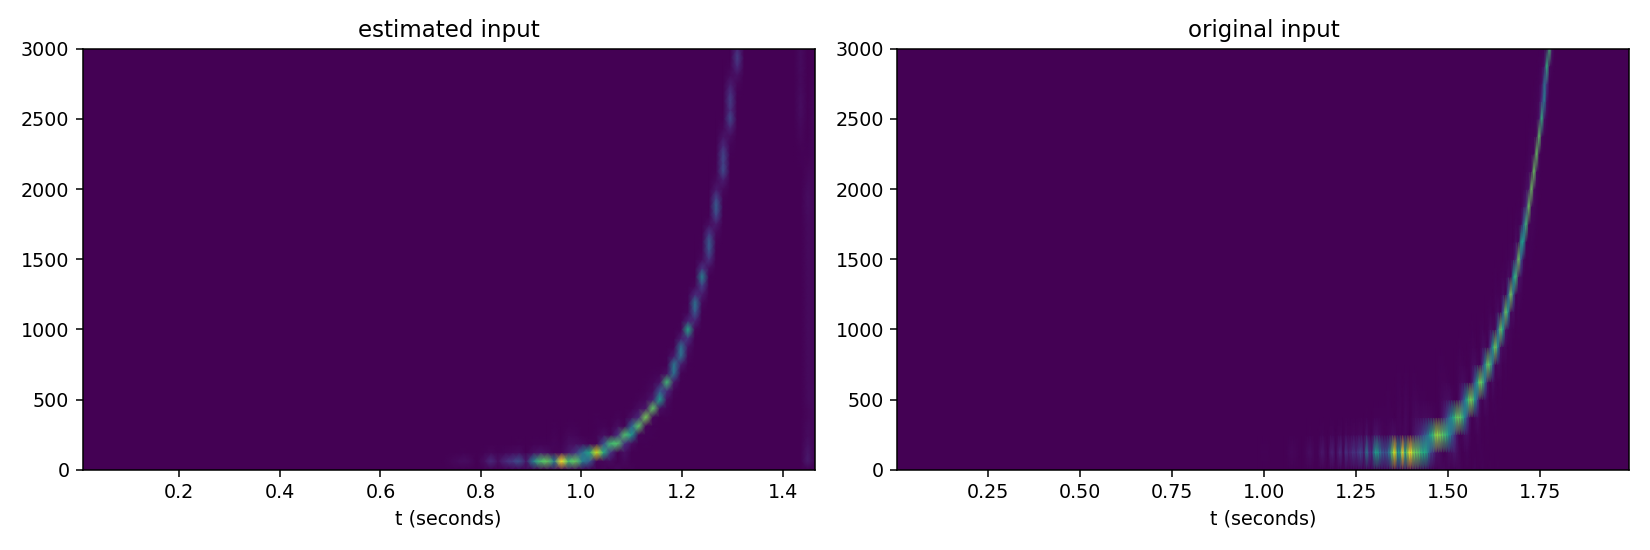

In [80]:
figure(6, figsize=(12,4))                                                                                                                    #with the original input signal
# ---------------------------------Plot of estimated input ---------------------------------------------
estimated_input = subplot(1,2,1)
f, t, Sxx = signal.spectrogram(Synthesizer.stimulus,Synthesizer.fs)
plt.pcolormesh(t, f, Sxx, shading='gouraud')                        
xlabel('t (seconds)')
ylim([0, 3000])
title('estimated input')
# ---------------------------------Plot of original input ---------------------------------------------
orignal_input = subplot(1,2,2)
f, t, Sxx = signal.spectrogram(b.stimulus,32000)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
xlabel('t (seconds)')
title('original input')
ylim([0, 3000])
tight_layout()